<a href="https://colab.research.google.com/github/jaycrossler/ai-training/blob/main/Using-Custom-LLM-Endpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Custom LLM Endpoints
## This must run within your company's firewall

This notebook demonstates how you can use LLMs that are hosted within your own organization/enterprise. In this notebook, we will be using Custom company hosted LLMs to demonstrate this. You will need to enter in a **COMPANY_API_KEY** into colab (the key icon on the left) as well as the company domain to point to.


In [1]:
%%capture --no-stderr
# install the required dependencies
%pip install -U langchain-openai langgraph langchain_openai

In [10]:
# If not using google colab, comment this out and enter your key below
from google.colab import userdata

CUSTOM_API_KEY = input("COMPANY_API_KEY:")
CUSTOM_DOMAIN = input("Domain to point API calls to (e.g. 'someplace.org'):")

COMPANY_API_KEY:It's a secret...
Domain to point API calls to (e.g. 'someplace.org'):someplace.org


In [4]:
from typing import Optional, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
import random

# Input Object
class InputState(TypedDict):
    query: str

# Output Object
class OutputState(InputState):
    dice_roll: int
    user_guess: int
    response: str

# Create a generic client
def create_generic_client(
    base_url: str,
    model: str,
    api_key: str,
    temperature=0.8,
):
    return ChatOpenAI(
        temperature=temperature,
        api_key=api_key,
        base_url=base_url,
        model=model,
        top_p=0.3,
    )

# Custom hosted LLM Endpoints
# Mixtral 22B parameter
CUSTOM_MIXTRAL_8x22B_URL = "https://mixtral-8x22b.k8s.aip.{}/v1".format(CUSTOM_DOMAIN)
CUSTOM_MIXTRAL_8x22B_MODEL = "mistralai/Mixtral-8x22B-Instruct-v0.1"

# Llama 70B parameter
CUSTOM_LLAMA_11B_URL = "https://llama32-11b.k8s.aip.{}/v1".format(CUSTOM_DOMAIN)
CUSTOM_LLAMA_11B_MODEL = "meta/llama-3.2-11b-vision-instruct"

# Feel free to choose one of the two LLM endpoints defined above
# Here, we are using the Mixtral endpoint/model
client = create_generic_client(base_url=CUSTOM_MIXTRAL_8x22B_URL,
                               model=CUSTOM_MIXTRAL_8x22B_MODEL,
                               api_key=CUSTOM_API_KEY)

async def user_guess(state: InputState) -> OutputState:
    messages = [
        (
            "system",
            "You are a helpful assistant. Extract the users guess for the dice roll and return the guess as a numerical value. Do not provide any explanation, just the number that the user guessed",
        ),
        ("human", state["query"]),
    ]

    guess = client.invoke(messages).content
    return OutputState(user_guess=int(guess))


async def roll_dice(state: OutputState) -> OutputState:
    return OutputState(dice_roll=random.randint(1, 6))

async def success_message(state: OutputState) -> OutputState:
    return OutputState(response="Congratulations!!!! You hit the Jackpot")

async def passifying_message(state: OutputState) -> OutputState:
    response = client.invoke("In 2 to 3 sentences, tell a shirt positive, uplifting story to cheer someone up when they are down on their luck.")
    return OutputState(response=response.content)


async def router(state: OutputState) -> Literal["success", "failure"]:
    return "success" if state["dice_roll"]==state["user_guess"] else "failure"


In [5]:
# Set up a workflow for multiple AI states (in LangGraph format)
workflow_builder = StateGraph(input=InputState, output=OutputState)
workflow_builder.add_node("guess", user_guess)
workflow_builder.add_node("roll_the_dice", roll_dice)
workflow_builder.add_node("success", success_message)
workflow_builder.add_node("failure", passifying_message)

workflow_builder.add_edge(START, "guess")
workflow_builder.add_edge("guess", "roll_the_dice")
workflow_builder.add_conditional_edges("roll_the_dice", router)
workflow_builder.add_edge("success", END)
workflow_builder.add_edge("failure", END)

workflow = workflow_builder.compile()


<ipython-input-5-056fdb2cbe29>:2: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  workflow_builder = StateGraph(input=InputState, output=OutputState)


Visulaizing the Workflow...


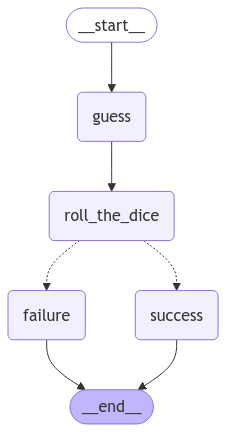

In [6]:
# Visualize the LangGraph workflow as a graph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

print("Visulaizing the Workflow...")

display(
    Image(
        workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [7]:
# Execute the LangGraph workflow
# Note - if you get a "Connection Error", that means your connection is probably blocked - you might
# be outside your corporate firewall.

response = await workflow.ainvoke(
        InputState(
            query='My guess is a 5',
        )
    )

print(f'User Guessed - {response["user_guess"]}')
print(f'Dice Roll - {response["dice_roll"]}')
print(f'Final Response - {response["response"]}')


APIConnectionError: Connection error.